In [1]:
import sys
import os
import operator
import copy
import re

import numpy as np
import pandas as pd

#import statsmodels.api as sm
#from statsmodels.formula.api import logit, probit, poisson, ols
from scipy import stats
from sklearn import linear_model, datasets
from sklearn.linear_model import LogisticRegression

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from collections import defaultdict

33.6336336336
6.40640640641


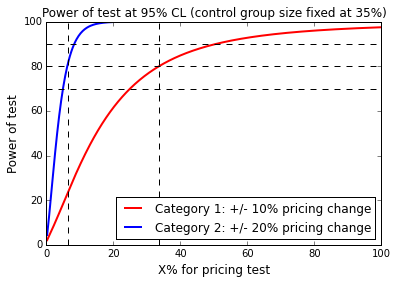

In [107]:
class Power_Estimator(object):

    def __init__(self, N, ctrl_frac, trt_frac, ctrl_eff, trt_eff, CL, n_bins):
        
        self._CL = CL
        self._ctrl_n = N * ctrl_frac
        self._trt_n = N * trt_frac
        
        self._ctrl_eff = ctrl_eff
        self._trt_eff = trt_eff
        
        self._pool_eff = (self._ctrl_eff * self._ctrl_n + self._trt_eff * self._trt_n) / (self._ctrl_n + self._trt_n)
        
    def get_power(self, one_side = True):
        
        h0_mean = 0
        h0_sigma = np.sqrt(self._pool_eff * (1 - self._pool_eff) * (1/self._ctrl_n + 1/self._trt_n))     
        #z_alpha = stats.norm.ppf(1-(1-self._CL)/10)
        z_alpha = stats.norm.ppf(1-(1-self._CL)/n_bins)
        #z_alpha = stats.norm.ppf(self._CL)
        
        #print('h0 mean: %0.3f, h0 sigma: %0.3f, z alpha %0.3f' % (h0_mean, h0_sigma, z_alpha))
        
        critical = h0_mean + z_alpha * h0_sigma
        
        h1_mean = self._trt_eff - self._ctrl_eff
        h1_sigma = np.sqrt(self._ctrl_eff * (1 - self._ctrl_eff) / self._ctrl_n + 
                           self._trt_eff * (1 - self._trt_eff) / self._trt_n)
        
        power = 1 - stats.norm.cdf(-1 * (h1_mean - critical) / h1_sigma)
        
        #print('h1 mean: %0.3f, h1 sigma: %0.3f, z beta %0.3f' % (h1_mean, h1_sigma, (h1_mean - critical) / h1_sigma))
        
        result = {}
        
        result['power'] = power
        result['h0_mean'] = h0_mean
        result['h0_sigma'] = h0_sigma
        result['z_alpha'] = z_alpha
        result['h1_mean'] = h1_mean
        result['h1_sigma'] = h1_sigma
        result['z_beta'] = (h1_mean - critical) / h1_sigma      
        
        return(result)
    
#     def __init__(self, sample_size, ctrl_frac, trt_frac, ctrl_eff, trt_eff, confidence_level):
        
#         self._confidence_level = confidence_level
        
#         self._ctrl_size = sample_size * ctrl_frac
#         self._trt_size = sample_size * trt_frac
        
#         self._ctrl_eff = ctrl_eff
#         self._trt_eff = trt_eff
        
#         self._ctrl_err = np.sqrt(self._ctrl_eff * (1 - self._ctrl_eff) / self._ctrl_size)
#         self._trt_err = np.sqrt(self._trt_eff * (1 - self._trt_eff) / self._trt_size)
    
#     def get_power(self, one_side = True):
        
#         t_stat = stats.norm.ppf(1-(1-self._confidence_level)/10)
                   
#         a = 1 + t_stat **2 / self._trt_size
#         b = - (2*self._ctrl_eff + t_stat**2/self._trt_size)
#         c = self._ctrl_eff ** 2 - t_stat**2 * self._ctrl_eff*(1-self._ctrl_eff) / self._ctrl_size
        
#         eff_critical = (-b + np.sqrt(b**2 - 4*a*c)) / (2*a)
                
#         err_critical = np.sqrt(eff_critical * (1 - eff_critical) / self._ctrl_size)
        
#         t_stat_final = (eff_critical - self._trt_eff) / np.sqrt(self._trt_err ** 2 + err_critical ** 2)       
        
#         power = 1 - stats.norm.cdf(t_stat_final)
        
#         return(power)



# class CL_Estimator(object):
    
#     def __init__(self, sample_size, ctrl_frac, trt_frac, ctrl_eff, trt_eff):
        
#         self._ctrl_size = sample_size * ctrl_frac
#         self._trt_size = sample_size * trt_frac
        
#         self._ctrl_eff = ctrl_eff
#         self._trt_eff = trt_eff
        
#         self._ctrl_err = np.sqrt(self._ctrl_eff * (1 - self._ctrl_eff) / self._ctrl_size)
#         self._trt_err = np.sqrt(self._trt_eff * (1 - self._trt_eff) / self._trt_size)
        
#     def get_CL(self, one_side = True):
                
#         t_stat = (self._trt_eff - self._ctrl_eff) / np.sqrt(self._trt_err ** 2 + self._ctrl_err ** 2)
        
#         if one_side == True:
#             pval = 1 - stats.norm.cdf(t_stat)
#         else:
#             pval = 2 * (1 - stats.norm.cdf(t_stat))
        
#         pval *= 10
        
#         if pval >= 1:
#             cl = 0
#         else:
#             cl = 1 - pval
        
#         return(cl)
    
    
    
# class Frac_Estimator(object):

#     def __init__(self, sample_size, confidence_level, n_trts, ctrl_eff, trt_eff):
        
#         self._sample_size = sample_size
#         self._confidence_level = confidence_level        
            
#         self._n_trts = n_trts
        
#         self._ctrl_eff = ctrl_eff
#         self._trt_eff = trt_eff   
    
#     def get_size(self, one_side = True):
        
#         if one_side == True:
#             t_stat = stats.norm.ppf(self._confidence_level)
#         else:
#             t_stat = stats.norm.ppf(self._confidence_level + (1 - self._confidence_level) / 2)
            
#         c1 = self._trt_eff * (1 - self._trt_eff)
#         c2 = self._ctrl_eff * (1 - self._ctrl_eff)
        
#         a = ((self._trt_eff - self._ctrl_eff) / t_stat)**2 * self._sample_size * self._n_trts
        
#         b = c2 - self._n_trts * c1 - ((self._trt_eff - self._ctrl_eff) / t_stat)**2 * self._sample_size
        
#         c = c1  
        
#         est_frac = (-b - np.sqrt(b**2 - 4*a*c)) / (2*a)
        
#         return(est_frac)


########################
## Analysis starts here
########################


    
#test_frac = np.linspace(0, 0.2, num=1000)
test_frac = np.linspace(0, 1, num=1000)
test_power = []
test_2_power = []

n_bins = 6
magnitude = 1.1
magnitude_2 = 1.2


for x in test_frac:
    # Half of the test x will be allocated to down shift, and half up => control is 1 - 2*x
    #power = Power_Estimator(120000, (1 - 2*x) * 0.1, x * 0.1, 0.32, 0.32 * 1.15, 0.95) 
    power = Power_Estimator(120000, 0.35 / n_bins, x / n_bins, 0.32, 0.32 * magnitude, 0.95, n_bins) 
    #power = Power_Estimator(120000, (1 - 2*x), x, 0.32, 0.32 * 1.1, 0.95)   
    test_power.append(power.get_power(one_side = True)['power'])
    
    power_2 = Power_Estimator(120000, 0.35 / n_bins, x / n_bins, 0.32, 0.32 * magnitude_2, 0.95, n_bins) 
    test_2_power.append(power_2.get_power(one_side = True)['power'])

    
def get_threshold(test_frac, test_power):

    first_90 = True
    first_80 = True
    first_70 = True

    threshold_90 = 0
    threshold_80 = 0
    threshold_70 = 0

    for x, power in zip(2 * test_frac * 100, np.array(test_power) * 100):
        if power >= 90 and first_90 == True:
            #print(x, power)
            threshold_90 = x
            first_90 = False 
        if power >= 80 and first_80 == True:
            #print(x, power)
            threshold_80 = x
            first_80 = False 
        if power >= 70 and first_70 == True:
            #print(x, power)
            threshold_70 = x
            first_70 = False  
    return(threshold_70, threshold_80, threshold_90)
    
test_threshold_70 = get_threshold(test_frac, test_power)[0]
test_threshold_80 = get_threshold(test_frac, test_power)[1]
test_threshold_90 = get_threshold(test_frac, test_power)[2]

test_2_threshold_70 = get_threshold(test_frac, test_2_power)[0]
test_2_threshold_80 = get_threshold(test_frac, test_2_power)[1]
test_2_threshold_90 = get_threshold(test_frac, test_2_power)[2]

print(test_threshold_80)
print(test_2_threshold_80)

    
fig, ax = plt.subplots()
ax.plot(2 * test_frac * 100, np.array(test_power) * 100, linewidth = 2, color = 'red', label = 'Category 1: +/- 10% pricing change')
ax.plot(2 * test_frac * 100, np.array(test_2_power) * 100, linewidth = 2, color = 'blue', label = 'Category 2: +/- 20% pricing change')
ax.set_xlabel('X% for pricing test', fontsize = 12)
ax.set_ylabel('Power of test', fontsize = 12)
ax.set_title('Power of test at 95% CL (control group size fixed at 35%)')
ax.axhline(y=90, linestyle='--', color='black', linewidth=1)
ax.axhline(y=80, linestyle='--', color='black', linewidth=1)
ax.axhline(y=70, linestyle='--', color='black', linewidth=1)

#ax.axvline(x=test_threshold_90, linestyle='--', color='black', linewidth=1)
ax.axvline(x=test_threshold_80, linestyle='--', color='black', linewidth=1)
#ax.axvline(x=test_threshold_70, linestyle='--', color='black', linewidth=1)

ax.axvline(x=test_2_threshold_80, linestyle='--', color='black', linewidth=1)

#ax.set_xlim(0, 20)
ax.set_xlim(0, 100)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc = 'best', fontsize = 12)
plt.savefig('size_estimation.png')



# test_cl = np.linspace(0, 1, num=50)
# test_power_n1 = []
# test_power_n2 = []
# test_power_n3 = []
# for x in test_cl: 
#     test_power_n1.append(Power_Estimator(120000, 
#                                          (1 - 2*0.01) * 0.1, 0.01 * 0.1, 
#                                          0.32, 0.32 * 1.2, x).get_power(one_side = True)['power'])
#     test_power_n2.append(Power_Estimator(120000, 
#                                          (1 - 2*0.05) * 0.1, 0.05 * 0.1, 
#                                          0.32, 0.32 * 1.2, x).get_power(one_side = True)['power'])
#     test_power_n3.append(Power_Estimator(120000, 
#                                          (1 - 2*0.10) * 0.1, 0.10 * 0.1, 
#                                          0.32, 0.32 * 1.2, x).get_power(one_side = True)['power'])
# fig, ax = plt.subplots()
# ax.plot(np.array(test_cl) * 100, np.array(test_power_n1) * 100, label = 'X% = 1%')
# ax.plot(np.array(test_cl) * 100, np.array(test_power_n2) * 100, label = 'X% = 5%')
# ax.plot(np.array(test_cl) * 100, np.array(test_power_n3) * 100, label = 'X% = 10%')
# ax.set_xlabel('Confidence level', fontsize = 12)
# ax.set_ylabel('Power of test', fontsize = 12)
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles, labels, loc = 'best', fontsize = 12)
# ax.set_xlim(0, 105)
# ax.set_ylim(0, 105)
# plt.savefig('power_and_CL.png')



/Users/xwang/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 51 but corresponding boolean dimension is 50
/Users/xwang/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 51 but corresponding boolean dimension is 50
/Users/xwang/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:23: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 51 but corresponding boolean dimension is 50
/Users/xwang/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 51 but corresponding boolean dimension is 50
/Users/xwang/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comp

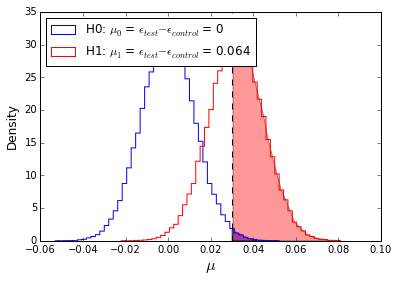

In [71]:


power = Power_Estimator(120000, (1 - 2*0.075) / n_bins, 0.075 / n_bins, 0.32, 0.32 * magnitude, 0.95, n_bins)
#power = Power_Estimator(120000, (1 - 2*0.075), 0.075, 0.32, 0.32 * 1.1, 0.95)
power.get_power(one_side = True)['power']


h0 = np.random.normal(power.get_power(one_side = True)['h0_mean'], power.get_power(one_side = True)['h0_sigma'], 50000)
h1 = np.random.normal(power.get_power(one_side = True)['h1_mean'], power.get_power(one_side = True)['h1_sigma'], 50000)

fig, ax = plt.subplots()
fig.set_size_inches(6.1, 4.1)
n1, bins1, patches1 = ax.hist(x = h0, normed = True, bins = 50, color = 'blue', label = r'H0: $\mu_{0}$ = $\epsilon_{test} - \epsilon_{control}$ = 0', histtype='step')
n2, bins2, patches2 = ax.hist(x = h1, normed = True, bins = 50, color = 'red', label = r'H1: $\mu_{1}$ = $\epsilon_{test} - \epsilon_{control}$ = 0.064', histtype='step')
ax.axvline(x=power.get_power(one_side = True)['h0_mean'] + 
           power.get_power(one_side = True)['z_alpha'] * power.get_power(one_side = True)['h0_sigma'], 
           linestyle='--', color='black', linewidth=1)
critical1 = bins1 >= power.get_power(one_side = True)['h0_mean'] + power.get_power(one_side = True)['z_alpha'] * power.get_power(one_side = True)['h0_sigma'] - (min(bins2)+max(bins2))/(len(bins2) - 1) 
critical2 = bins2 >= power.get_power(one_side = True)['h0_mean'] + power.get_power(one_side = True)['z_alpha'] * power.get_power(one_side = True)['h0_sigma'] - (min(bins2)+max(bins2))/(len(bins2) - 1) 
b1 = [(bins1[critical1][i] + bins1[critical1][i+1])/2 for i, b in enumerate(bins1[critical1[:-1]])]
b2 = [(bins2[critical2][i] + bins2[critical2][i+1])/2 for i, b in enumerate(bins2[critical2[:-1]])]
ax.fill_between(b1,
                np.repeat(0, len(bins1[critical1[:-1]])),
                n1[critical1[:-1]], 
                facecolor='blue', alpha=0.6)
ax.fill_between(b2,
                np.repeat(0, len(bins2[critical2[:-1]])),
                n2[critical2[:-1]], 
                facecolor='red', alpha=0.4)
ax.set_xlabel(r'$\mu$', fontsize = 16)
ax.set_ylabel('Density', fontsize = 12)
ax.set_ylim(0, 35)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc = 'upper left', fontsize = 12)
plt.savefig('significance_level_and_power.png')


# test_frac = np.linspace(0, 0.1, num=50)
# #test_frac = np.array([0.00083530078347806419, 0.0012776508454989293, 0.0021063583124981662])
# test_cl = []

# for x in test_frac:
#     # Half of the test x will be allocated to down shift, and half up => control is 1 - 2*x
#     #cle = CL_Estimator(120000, 1 - 2*x, x, 0.32, 0.32 * 1.2)
#     cle = CL_Estimator(120000, (1 - 2*x) * 0.5 * 0.1, x * 0.1, 0.32, 0.32 * 1.2)
    
#     test_cl.append(cle.get_CL(one_side = True))

    
# fig, ax = plt.subplots()
# ax.plot(2 * test_frac * 100, np.array(test_cl) * 100)
# ax.set_xlabel('X% for pricing test', fontsize = 12)
# ax.set_ylabel('confidence level', fontsize = 12)
# ax.axhline(y=95, linestyle='--', color='black', linewidth=1)
# ax.axhline(y=90, linestyle='--', color='black', linewidth=1)
# ax.axhline(y=85, linestyle='--', color='black', linewidth=1)
# ax.set_xlim(0, 10)
# #plt.savefig('size_estimation.png')



# test_cl = np.linspace(0, 1, num=1000)
# #test_cl = np.array([0.85, 0.9, 0.95])
# test_frac = []

# for x in test_cl:
#     # Half of the test x will be allocated to down shift, and half up => control is 1 - 2*x
#     spe = Frac_Estimator(120000, x, 2, 0.32, 0.32 * 1.2)
#     #spe = Frac_Estimator(120000, x, x, 0.32, 0.32 * 1.2)
    
#     test_frac.append(spe.get_size(one_side = True))

    
# fig, ax = plt.subplots()
# ax.plot(test_cl * 100, np.array(test_frac) * 100)
# ax.set_xlabel('confidence level', fontsize = 12)
# ax.set_ylabel('X% for pricing test', fontsize = 12)
# ax.set_xlim(50, 100)
# ax.axvline(x=95, linestyle='--', color='black', linewidth=1)
# ax.axvline(x=90, linestyle='--', color='black', linewidth=1)
# ax.axvline(x=85, linestyle='--', color='black', linewidth=1)
    
        

In [14]:
120000 * 0.002 

240.0

In [15]:
120000 * 0.996

119520.0

In [17]:
(0.37 - 0.32) / np.sqrt( 0.37 * (1-0.37) / 240 + 0.32 * (1-0.32)/ 119520 )

1.6028682458027426

In [26]:
#1 - stats.norm.cdf(1.6028682458027426)
1 - stats.norm.cdf(1.036433)

0.1500000908139133

In [22]:
np.sqrt( 0.37 * (1-0.37) / 240)

0.031164884084494842

In [23]:
np.sqrt( 0.32 * (1-0.32)/ 119520)

0.0013493019663957401

In [51]:
np.linspace(0, 1, num=20)

array([ 0.        ,  0.05263158,  0.10526316,  0.15789474,  0.21052632,
        0.26315789,  0.31578947,  0.36842105,  0.42105263,  0.47368421,
        0.52631579,  0.57894737,  0.63157895,  0.68421053,  0.73684211,
        0.78947368,  0.84210526,  0.89473684,  0.94736842,  1.        ])

In [86]:
120000 * 0.1

12000.0

In [87]:
(6000+6000)/120000

0.1

In [88]:
600/(600+10800)

0.05263157894736842

In [89]:
stats.norm.ppf(0.95)

1.6448536269514722